In [96]:
import gc
import pandas as pd
import numpy as np
import geopandas as gpd
import sqlite3
from shapely import wkt
pd.set_option('display.max_columns', 100)
from shapely.geometry import Point, Polygon
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [56]:
alg_conn = sqlite3.connect("/home/betorcha/Ml_projects/osm_data/osm_wilayats_sqlite/osm_Algiers.db")

In [57]:
df = pd.read_sql("select * from osm_Algiers", con= alg_conn)
df['geometry'] = gpd.GeoSeries.from_wkt(df['WKT_GEOMETRY'])
df = df.drop('WKT_GEOMETRY', axis = 1)
gdf = gpd.GeoDataFrame(df, geometry= 'geometry')
gdf.crs = 4326
del df
_ = gc.collect()

In [9]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 428598 entries, 0 to 428597
Data columns (total 35 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   ogc_fid      428598 non-null  int64   
 1   osm_id       82066 non-null   object  
 2   name         23334 non-null   object  
 3   highway      48623 non-null   object  
 4   waterway     174 non-null     object  
 5   aerialway    10 non-null      object  
 6   barrier      2246 non-null    object  
 7   man_made     739 non-null     object  
 8   railway      649 non-null     object  
 9   z_order      49589 non-null   float64 
 10  other_tags   73042 non-null   object  
 11  ref          221 non-null     object  
 12  address      0 non-null       object  
 13  is_in        0 non-null       object  
 14  place        424 non-null     object  
 15  type         1279 non-null    object  
 16  osm_way_id   346532 non-null  object  
 17  aeroway      97 non-null      object  
 

#### Must common shop name in algeirs is : "Epicerie and Kiosque!"

<Axes: >

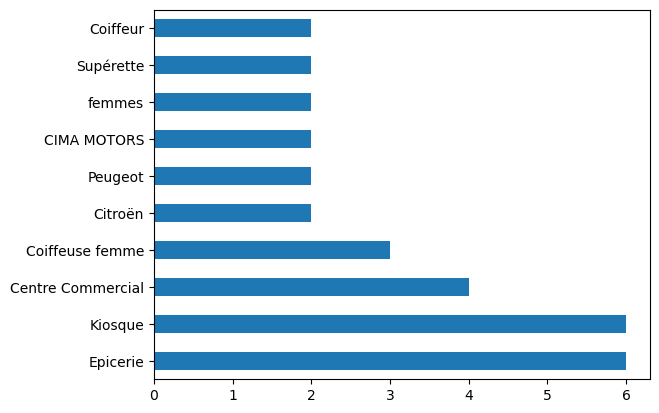

In [21]:
(
    gdf
    .loc[(~gdf.name.isnull()) & (~ gdf.shop.isnull())]
    .name
    .value_counts()
    .iloc[:10]
    .plot
    .barh()
)

<Axes: >

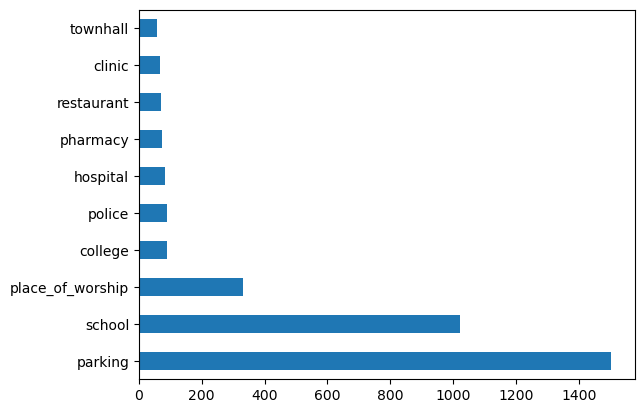

In [25]:
gdf.amenity[~gdf.amenity.isnull()].value_counts().iloc[:10].plot.barh()

### Education infrastructure distirbution in Algiers

In [67]:
education = gdf[gdf.amenity.isin(["school", "college", 'university'])].loc[:, ['amenity', 'geometry']]
education.head()

,amenity,geometry
81205,school,"MULTIPOLYGON (((3.14765 36.65383, 3.14720 36.6..."
81340,university,"MULTIPOLYGON (((3.00728 36.77765, 3.00750 36.7..."
81349,school,"MULTIPOLYGON (((3.00495 36.76935, 3.00518 36.7..."
81350,school,"MULTIPOLYGON (((3.00475 36.76989, 3.00444 36.7..."
81360,college,"MULTIPOLYGON (((3.00194 36.76637, 3.00194 36.7..."


In [42]:
def partition(geom, delta):

    def grid_bounds(geom, delta):
        minx, miny, maxx, maxy = geom.bounds
        nx = int((maxx - minx)/delta)
        ny = int((maxy - miny)/delta)
        gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
        grid = []
        for i in range(len(gx)-1):
            for j in range(len(gy)-1):
                poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
                grid.append( poly_ij )
        return grid

    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))

    return grid


<Axes: >

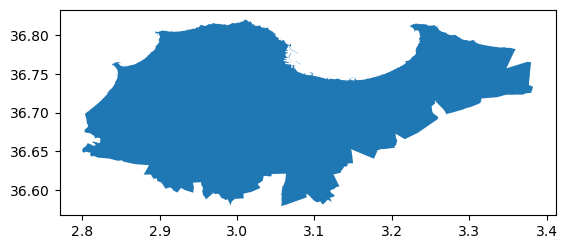

In [41]:
# Get Algieirs geom
alg_dec = sqlite3.connect("/home/betorcha/Ml_projects/osm_data/data/dz_decoupage.db")
alg = pd.read_sql("select WKT_GEOMETRY from all_wilayas where name == 'Algiers';", con=alg_dec)
alg = gpd.GeoSeries.from_wkt(alg['WKT_GEOMETRY'])
display(alg.plot())

<Axes: >

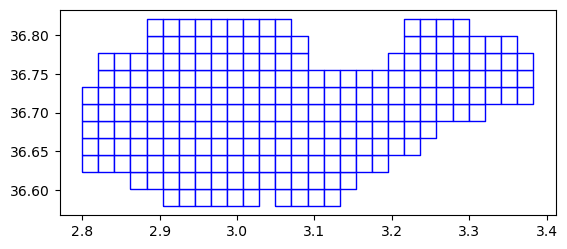

In [89]:
alg_grid = partition(geom = alg.geometry[0], delta = 2e-2)
alg_grid = gpd.GeoDataFrame(geometry = alg_grid)
alg_grid.plot(color="white", edgecolor="blue")

In [90]:
# let now merge gdf and alg_grid 
alg_grid.crs = 4326
merged = gpd.sjoin(education, alg_grid, how='left')

In [91]:
types = ["school", "college", "university"]
dissolve = merged.groupby(["index_right", "amenity"])["amenity"].count().to_frame().unstack()
dissolve.columns = dissolve.columns.droplevel(level=0)
dissolve["total"] = dissolve.sum(axis=1)
dissolve["main"] = "none"
for _type in types:
    dissolve.loc[dissolve[_type]/dissolve["total"] > 0.5, "main" ] = _type

# include counts and type in grid
alg_grid.loc[dissolve.index, "total_venues"] = dissolve["total"].values
alg_grid.loc[dissolve.index, "main_venue"] = dissolve["main"].values
grid = alg_grid

In [92]:
#calculate center of each grid cell
grid["center"] = grid["geometry"].centroid

#filter for cells with at least one venue
centroids = grid[grid["total_venues"]>=0]

# convert to new gdf with 'centroid' as the geometry
centroids = gpd.GeoDataFrame(centroids.drop(columns="geometry"), geometry = "center")
centroids = centroids.to_crs(grid.crs)

/tmp/ipykernel_9718/1842491352.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid["center"] = grid["geometry"].centroid


In [93]:
#set colours for venue type
colours = {'school': '#5CE349', 'college': '#6E62FD', 'none': '#F9965B', 'university': '#38B6B8'}
bg_color="#111111"
font_color="#eaeaea"

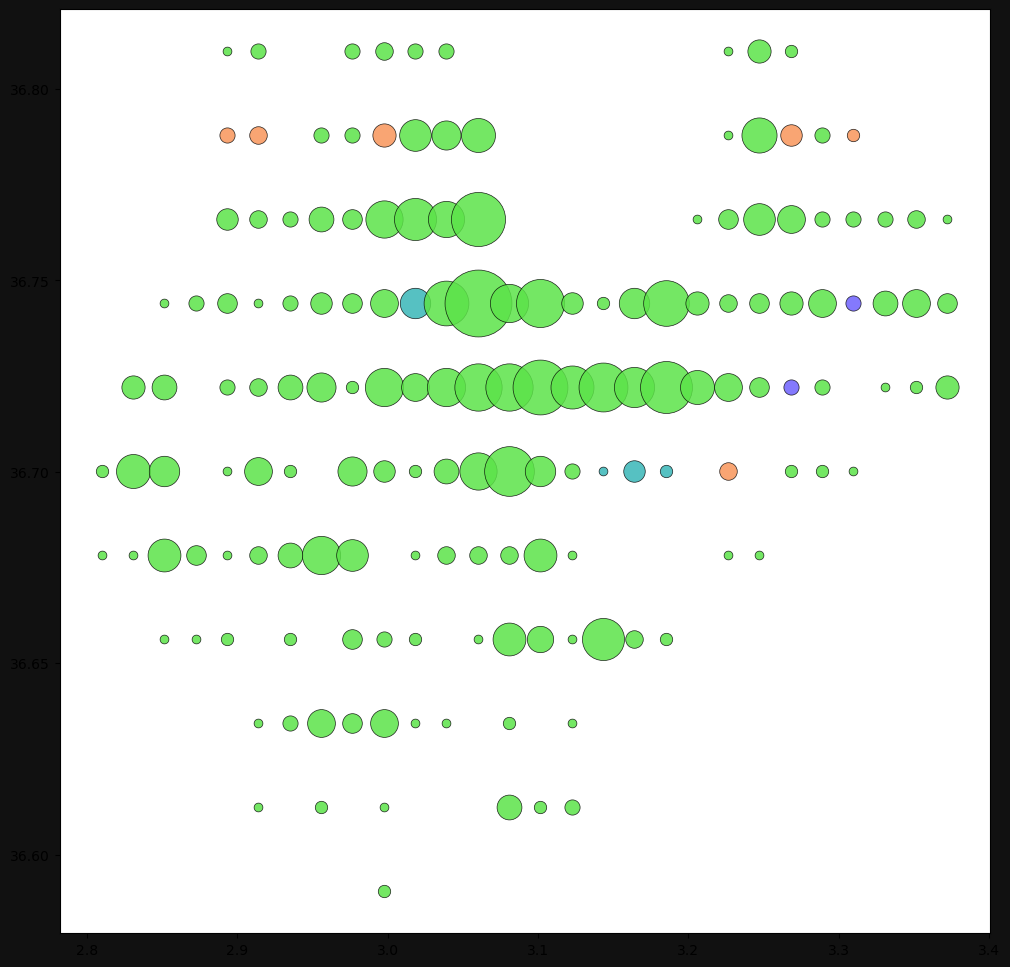

In [99]:

#plot
fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor(bg_color)

# ===
# Data
for i in range(len(centroids)):
    ax.scatter(centroids["center"].x.iloc[i], centroids["center"].y.iloc[i],
               s=centroids["total_venues"].iloc[i]*40, marker="o", color=colours[centroids["main_venue"].iloc[i]], 
               alpha=0.85, 
               edgecolor="black", clip_on=False, linewidth=0.5)

